In [1]:
#import pacakges
import numpy as np
from nn import (nn, io, preprocess)
import sklearn.datasets as sk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#Read in data
pos = io.read_text_file('data/rap1-lieb-positives.txt')
neg = io.read_fasta_file('data/yeast-upstream-1k-negative.fa')

To deal with the difference is seqs lengths, we will truncate the longer seqs

In [3]:
#Find the length of shoter seqs
for i in range(len(neg)):
    neg[i] = neg[i][:len(pos[0])]

In [4]:
#Create label vectors
pos_label = [1 for i in range(len(pos))]
neg_label = [0 for i in range(len(neg))]

In [5]:
seqs = pos + neg
labels = pos_label + neg_label

In [6]:
#Balence classes with sample_seqs
sampled_seqs, sampled_labels = preprocess.sample_seqs(seqs, labels)

Sampling Scheme

We want the same number of items in each class. One way to go about this would be to choose all items in the smaller class and randomly sample from the larger class until you get the same amount. This causes an issue of being restricted by the size of the smaller classs and one of the sets is the true population while the other is a sample, possibly introducing some bias. Another choise then is to choose all the larger set and randomly sample with replacement from the smaller until you reach the same size, but this introduces duplicates only to the smaller set, once again causing a potential bias.

A third solution that avoids these problems is to specify the number we want in both classes post sampling (set to 1000 each here) and the sampling from both with replacement until that size is reach. This introduces duplicated to both classes and stops a representation bias.

In [7]:
sampled_labels = np.array(sampled_labels)

In [9]:
#One hot encode
sampled_seqs = preprocess.one_hot_encode_seqs(sampled_seqs)

In [12]:
#Split into training and validation sets
X_val, X_train, y_val, y_train = train_test_split(sampled_seqs, sampled_labels, test_size=0.8, random_state= 74)

In [13]:
y_val = np.reshape(y_val, (1,np.shape(y_val)[0]))
y_train = np.reshape(y_train, (1,np.shape(y_train)[0]))

In [22]:
#Generate nn architecture
num_feat = np.shape(X_val)[1]
arch = [{'input_dim': num_feat, 'output_dim': 35, 'activation': 'relu'}, {'input_dim': 35, 'output_dim': 1, 'activation': 'sigmoid'}]

In [23]:
batch_size = np.shape(X_train)[0]

In [33]:
#Generate an instance of the nn
classifier_nn = nn.NeuralNetwork(arch, lr = 0.5, seed = 42, batch_size=batch_size, epochs= 50000, loss_function= 'BCE')

In [34]:
per_epoch_loss_train,per_epoch_loss_val = classifier_nn.fit(X_train, y_train, X_val, y_val)

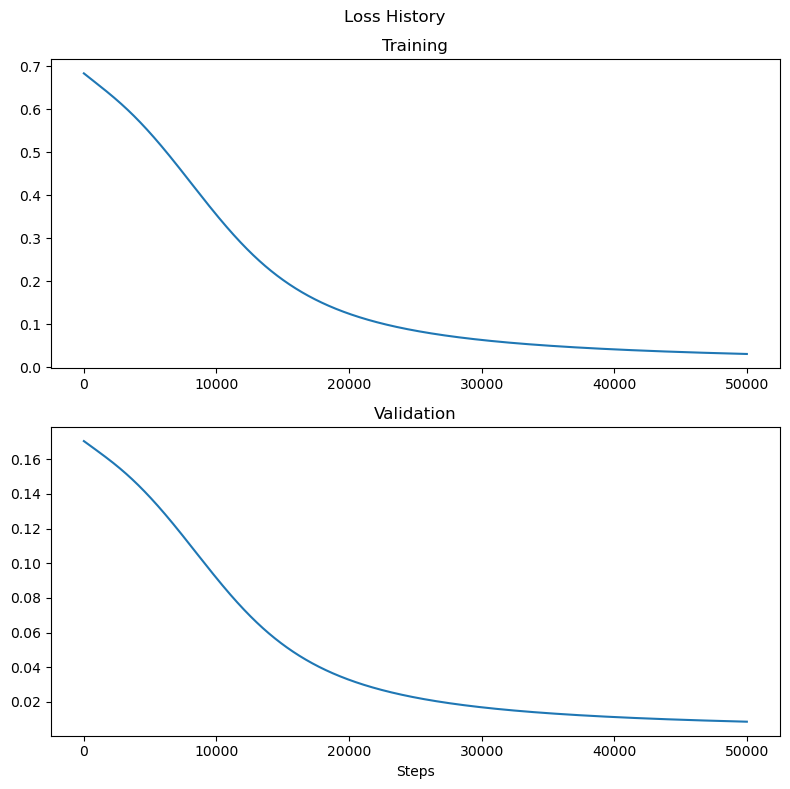

In [35]:
# Create plot
fig, axs = plt.subplots(2, figsize=(8, 8))
fig.suptitle('Loss History')
axs[0].plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
axs[0].set_title('Training')
axs[1].plot(np.arange(len(per_epoch_loss_val)), per_epoch_loss_val)
axs[1].set_title('Validation')
plt.xlabel('Steps')
fig.tight_layout()
plt.show()

In [55]:
#Make predictions on the validation set
y_hat_val = classifier_nn.predict(X_val)
pred = y_hat_val.T

In [71]:
#Calculate accuracy of the prediciton
num_correct = 0
for i in range(len(pred[0])):
    #Binarize the prediction
    if pred[0][i] > 0.5:
        pred[0][i] = 1
    else:
        pred[0][i] = 0
    
    #Count how many were correctly predicted
    if pred[0][i] == y_val[0][i]:
        num_correct = num_correct + 1

In [75]:
accuracy = num_correct / 400
print('Accuracy = ' + str(accuracy))

Accuracy = 0.9925


In [76]:
#Calculatunf more detailed stats
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
for i in range(len(pred[0])):
    if pred[0][i] == 1 and pred[0][i] == y_val[0][i]:
        true_positive = true_positive + 1
    if pred[0][i] == 1 and pred[0][i] != y_val[0][i]:
        false_positive = false_positive + 1
    if pred[0][i] == 0 and pred[0][i] == y_val[0][i]:
        true_negative = true_negative + 1
    if pred[0][i] == 0 and pred[0][i] != y_val[0][i]:
        false_negative = false_negative + 1

In [79]:
#Report
print('Recall: ' + str(true_positive / (true_positive + false_negative)))
print('False Positive Rate: ' + str(false_positive / (false_positive + true_negative)))
print('Specificity: ' + str(true_negative / (true_negative + false_positive)))
print('Precision: ' + str(true_positive / (true_positive + false_positive)))

Recall: 1.0
False Positive Rate: 0.014285714285714285
Specificity: 0.9857142857142858
Precision: 0.9844559585492227


Hyperparameter optimization:

I chose binary cross entropy as the loss function because this is a binary classifier, where predictions are either a zero or a 1. Binary cross entropy is then particularly well suited for this case becasue it is designed around and for such a scenerio. For the hyperparameters, I again start at 0.01 for the learning rate and about 3x the number of epochs as the test set size. I then increase the learning rate as it seems it improces the convergence of the nn without showing signs of overfitting. Once I felt the learning rate was as large I was willing to go, I started to increase the epoch number until I got good predictions.